# Video Data Export
* Export labels from video annotation projects

In [1]:
!pip install labelbox
!pip install requests
!pip install numpy
!pip install PILLOW
!pip install matplotlib
!pip install ndjson
!pip install ipython
!pip install opencv-python

In [2]:
from labelbox import Client
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
from getpass import getpass
import ndjson
import requests
import cv2
from collections import Counter
from typing import Dict, Any
import os

In [3]:
# If you don't want to give google access to drive you can skip this cell
# and manually set `API_KEY` below.

COLAB = "google.colab" in str(get_ipython())
if COLAB:
    !pip install colab-env -qU
    from colab_env import envvar_handler
    envvar_handler.envload()

API_KEY = os.environ.get("LABELBOX_API_KEY")
if not os.environ.get("LABELBOX_API_KEY"):
    API_KEY = getpass("Please enter your labelbox api key")
    if COLAB:
        envvar_handler.add_env("LABELBOX_API_KEY", API_KEY)

In [4]:
# Pick a video project with completed bounding box labels
PROJECT_ID = "ckkr0jziacf2q0793a5rjx3md"
# Only update this if you have an on-prem deployment
ENDPOINT = "https://api.labelbox.com/graphql"

In [5]:
client = Client(api_key=API_KEY, endpoint=ENDPOINT)
project = client.get_project(PROJECT_ID)

### Export the labels

In [6]:
export_url = project.export_labels()

In [7]:
print(export_url)

https://storage.googleapis.com/labelbox-exports/ckkr0jzencf290793usnd4631/ckkr0jziacf2q0793a5rjx3md/export-2021-03-19T11%3A09%3A49.875Z.json?GoogleAccessId=api-staging%40labelbox-193903.iam.gserviceaccount.com&Expires=1617361792&Signature=Dz%2Fs6aQcMIeRJMKuKGPIaWpnxgNsxvpXJYAg2OIwhakJkPIhaiZxYmPIBFXgTNcmHATzzgAq1PcTUq6TIC2aIqeRXkZxHJXIPfGHcuOJ0twZ1ya6m16YV26AIOiswhbdwivnbvhYViDqVI79KZJYB004uHMb5mIPoxZ2dqpzP5kqnnTvWn7wHxt2DDGPyu8H6AVuJJdlcdA57vmUkPgPIDj8CXfSBWrXv81HboAGPNkgHA4dblVbBNWFruaGs84H3NjgbwrNCwB7oQrb%2FT9fP7a67rrUgMMYt5n2HYUoE5PzkHBHlS6RPx%2BU0E7QLpV3ItTuwwVlL8%2F%2FoZCYF1tLgg%3D%3D&response-content-disposition=attachment


In [8]:
exports = requests.get(export_url).json()

In [9]:
# One export for each data_row (video)
exports[0]

{'ID': 'ckkr0k076cf8o0793ky312s6t',
 'DataRow ID': 'ckkr0jzjecf5m0793i529wu9f',
 'Labeled Data': 'https://storage.labelbox.com/cjhfn5y6s0pk507024nz1ocys%2Fb8837f3b-b071-98d9-645e-2e2c0302393b-jellyfish2-100-110.mp4?Expires=1599704622298&KeyName=labelbox-assets-key-1&Signature=e-aanhvHBBYrkALl5Qr2n6H2QqA',
 'Label': {'frames': 'https://staging-api.labelbox.com/v1/frames/ckkr0k076cf8o0793ky312s6t'},
 'Created By': 'msokoloff@labelbox.com',
 'Project Name': 'Sample Video Project',
 'Created At': '2021-02-04T15:27:28.770Z',
 'Updated At': '2021-03-19T11:08:38.000Z',
 'Seconds to Label': 5.001,
 'External ID': 'jellyfish2-100-110.mp4',
 'Agreement': -1,
 'Benchmark Agreement': -1,
 'Benchmark ID': None,
 'Dataset Name': 'Example Jellyfish Dataset',
 'Reviews': [],
 'View Label': 'https://staging.labelbox.dev/editor?project=ckkr0jziacf2q0793a5rjx3md&label=ckkr0k076cf8o0793ky312s6t',
 'Has Open Issues': 0}

### Using the data
* Each frame's label must be fetched individually.

In [10]:
video_url = exports[0]["Labeled Data"]
annotations_url = exports[0]["Label"]["frames"]
# View the video in your browser by clicking on the link
print(video_url)

https://storage.labelbox.com/cjhfn5y6s0pk507024nz1ocys%2Fb8837f3b-b071-98d9-645e-2e2c0302393b-jellyfish2-100-110.mp4?Expires=1599704622298&KeyName=labelbox-assets-key-1&Signature=e-aanhvHBBYrkALl5Qr2n6H2QqA


In [11]:
with open("/tmp/sample_video.mp4", "wb") as file:
    file.write(requests.get(video_url).content)

#### Turn video into individual frames

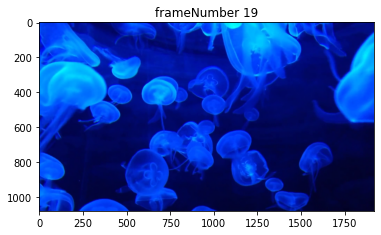

<Figure size 432x288 with 0 Axes>

In [12]:
vidcap = cv2.VideoCapture("/tmp/sample_video.mp4")
success, image = vidcap.read()
image = image[:, :, ::-1]
# Note that frameNumber 1 in the annotation is frame index 0s
count = 1
while success and count < 20:
    plt.figure(1)
    plt.imshow(image)
    plt.title('frameNumber ' + str(count))
    plt.pause(0.25)
    plt.clf()
    success, image = vidcap.read()
    count += 1
    if success and count < 20:
        clear_output(wait=True)
    image = image[:, :, ::-1]

In [13]:
headers = {"Authorization": f"Bearer {API_KEY}"}
annotations = ndjson.loads(requests.get(annotations_url, headers=headers).text)
# Make it easy to lookup
annotations = {annot["frameNumber"]: annot for annot in annotations}
print(annotations[1])

{'frameNumber': 1, 'classifications': [], 'objects': [{'featureId': 'ckkr0k068002q0z7a3u1p77l2', 'schemaId': 'ckkr0jzp0002p0z7aaqbmhiw2', 'title': 'Jellyfish', 'value': 'jellyfish', 'color': '#a23030', 'keyframe': True, 'bbox': {'top': 582, 'left': 1644, 'height': 340, 'width': 212}, 'classifications': []}, {'featureId': 'ckkr0k068002r0z7a924jdufv', 'schemaId': 'ckkr0jzp0002p0z7aaqbmhiw2', 'title': 'Jellyfish', 'value': 'jellyfish', 'color': '#a23030', 'keyframe': True, 'bbox': {'top': 712, 'left': 1256, 'height': 204, 'width': 330}, 'classifications': []}, {'featureId': 'ckkr0k068002s0z7a7k45cvp1', 'schemaId': 'ckkr0jzp0002p0z7aaqbmhiw2', 'title': 'Jellyfish', 'value': 'jellyfish', 'color': '#a23030', 'keyframe': True, 'bbox': {'top': 47, 'left': 155, 'height': 381, 'width': 330}, 'classifications': []}, {'featureId': 'ckkr0k068002t0z7a82zs35ja', 'schemaId': 'ckkr0jzp0002p0z7aaqbmhiw2', 'title': 'Jellyfish', 'value': 'jellyfish', 'color': '#a23030', 'keyframe': True, 'bbox': {'top': 7

In [14]:
def visualize_bbox(image: np.ndarray, tool: Dict[str, Any]) -> np.ndarray:
    """
    Draws a bounding box on an image
    
    Args:
        image (np.ndarray): image to draw a bounding box onto
        tool (Dict[str,any]): Dict response from the export
    Returns:
        image with a bounding box drawn on it.
    """
    start = (int(tool["bbox"]["left"]), int(tool["bbox"]["top"]))
    end = (int(tool["bbox"]["left"] + tool["bbox"]["width"]),
           int(tool["bbox"]["top"] + tool["bbox"]["height"]))
    return cv2.rectangle(image, start, end, (255, 0, 0), 5)

#### Visualize annotations overlaid onto individual frames

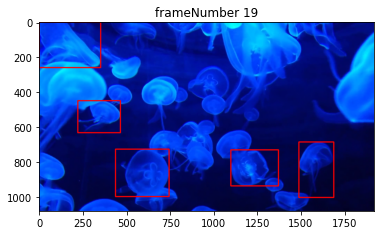

<Figure size 432x288 with 0 Axes>

In [15]:
vidcap = cv2.VideoCapture('/tmp/sample_video.mp4')
success, image = vidcap.read()
image = image[:, :, ::-1]
# Note that frameNumber 1 in the annotation is frame index 0
count = 1

while success and count < 20:
    annotation = annotations.get(count)
    if annotation is not None:
        for tool in annotation['objects']:
            image = visualize_bbox(image.astype(np.uint8), tool)
    plt.figure(1)
    plt.imshow(image)
    plt.title('frameNumber ' + str(count))
    plt.pause(0.25)
    plt.clf()

    success, image = vidcap.read()
    count += 1
    if success and count < 20:
        clear_output(wait=True)
    image = image[:, :, ::-1]